###### Last update: 2022-05-27 (YYYY-MM-DD)
# Example: Performing Fluid Flow Simulation using a Remote Server

## Author: Jerome O.
Note: If you intend to run this example, please send an email to info@thedibia.com or jerome.onwunalu@thedibia.com>

## 1. Introduction

This notebook shows a simple application of a remote API to perform simulate subsurface fluid flow in porous media. If you are not a petroleum or reservoir engineer, please see [reservoir simulation](https://en.wikipedia.org/wiki/Reservoir_simulation) for some background on reservoir simulation, and this blog for application using simple reservoir models. 

The example is based on a simple simulation model. The dimensions of the grid is 100 x 1 x 1. We have intentionally choosen a model with smaller grid because so the computations on remote server can finish sooner. Generally, larger models require more computational resources and the simulations require more time to complete.  

A main benefit of this API is that is would help students and researches from third-world countries who do not have access to third-party fluid simulators or advanced routines (such as in the application used here) to carry out advanced research. 

To use the API, a user creates data relevant for their simulation (see example below). They issue an HTTP request and if the simulation is successful, the result is a set of time-series parameters for different quantities. These time-series are used to create plots of the production profile vs. time. 

### 1.1 Synchronous vs. Asynchronous HTTP Requests
The methods for submitting the HTTP requests are provided. The **Synchronous** post request is a synchronous call and the requests blocks until the response is returned back to the client. This option is not very responsive and provides no status updates to the user. The **Asynchronous** post requests submits the request asynchronously and continously poss the remote server for job status (percent completion) and when the job is completed, returns the time-series objects.

We should always care about our users and their experience when using our applications. For this reason, the **asynchronous** call is recommended because it provide feedback on remote job status although it has a more complicated code (uses event-driven architecture and message queues). The **synchronous** request option is useful for testing and debugging purposes as its code path is much simpler. The results from both approaches are exactly the same.

## 2. Import packages and functions

In [51]:
import json, time, math
from demo_utils import create_project, get_request, submit_request, print_json, make_plot, progress_bar
from demo_utils import get_request_auth, post_request_auth, run_remote_job

## 3. Authorization Token

To be able to run the remote simulation, one needs an authorization **token** and a **project id** (key). To obtain a token to run the example model, please send an email with your first name to me at jerome.onwunalu@thedibia.com

### 3.1 Obtain Authorization Token

If you have obtained an authorization token, you can test that it works by issuing a GET http request to https://simapi.thedibia.com/hello. If the request is successful a JSON with key "message" and value "Hello <name>!" is returned.

### 3.2 Test Authorization Token
#### Get Request to Hello API

In [32]:
token        = '06829778a6474fe2c15d5687a315fba5f9e385ba' #<- add your token here # bermuda
auth_headers = {"Authorization" : f"Token {token}"}
hello_data   = None
url          = 'https://simapi.thedibia.com/hello'
results      = get_request_auth(hello_data, url, auth_headers)
if results:
    print_json(results)

{
    "message": "Hello tdba!"
}


## 4. Example 

### 4.1 Define Simulation Parameters: Well Types and Well Locations

Here we show how to define well parameters in the simulation model. Basically, we need to specify the **type** and **location** of the wells. The **type** of the well could be an oil **producer** (represented by 0) or a water **injector** (represented by 1). The oil producers produce oil to the surface while the water injector is used to injector water in the reservoir to improve recovery and maintain pressure. 

The **location** of each well is defined by specifying the (I,J,K) indices of the **start** and **end** grid blocks of the well. The start and end grid block of the first oil producer (named **producer_1**) are (100, 1, 1) and (100, 1, 1) respectively. For the second producer (**producer_2**) the start and end grids are (1,1, 1) and (1, 1, 1), and for the water injector (**injector_1**), the corresponding values are (50, 50, 1) and (50, 50, 1). The water injector is located in between the two production wells. See below for a complete specification of all the wells. See next section for a full specification of the wells.

### 4.2 Specifying Well Types and Locations

The model contains 2 oil producers and 1 water injector. The wells are defined as an array of well parameters. Each well is defined by three parameters:

1 - well type: 0 for producer, 1 for water injector

2 - well toe location grid specified by 3 indicies (i,j,k)

3 - well heel location grid specified by 3 indicies (i,j,k)

In [8]:
# Well parameters for the 3 wells of the reservoir model
well_parameters = [[0, [100,1,1],[100,1,1]],
                   [1, [50,1,1], [50,1,1]],
                   [0, [1,1,1],[1,1,1]]]    

### 4.3 Initialize token, project_id parameters

In [10]:
SIM_URL      = "https://simapi.thedibia.com/api/simulations"
project_id   =  "2d92db18-314d-4e5d-8f58-d079883af7f5"
sim_duration = 1000 # simulation duration in days # should be less than 10,000 days
  

## 5. Specify data for HTTP Post Request

Here we define JSON data that we will use to make the request to the remote application. There are additional data that can be specified in the JSON structure but I have opted for a simplified data format. Below we show an example JSON data that includes the well configurations ("parameters") and another to control the duration of the simulation ("simulation-duration"). The unit of the simulation duration is days.

### 5.1 Synchronous vs. Asynchronous HTTP Request

Both synchronous and asynchronous HTTP requests can be made depending on data passed to the remote machine. With a synchronous HTTP request, the requests blocks until the remote simulations is completed. For the asynchoronous case, the initial HTTP request returns and we keep polling to get status of the remote jobs. When the status is 100%, then the simulation results are return. Both approaches return exactly the same results.  We use a small model that runs fast (few seconds) and so we can use an synchronous call. For longer running jobs, the async procedure is best.

In [56]:
# SYNCHRONOUS CALL
# synchronous remote call (no updates on status of remote simulation job) For this case, the call blocks until the
# remote simulation is complete
data_no_updates ={           
                  'project_id'          : project_id,       
                  'parameters'          : str(json.dumps(well_parameters)), 
                  'simulation-duration' : sim_duration
                 }
print_json(data_no_updates)
#str(data_no_updates)

{
    "project_id": "2d92db18-314d-4e5d-8f58-d079883af7f5",
    "parameters": "[[0, [100, 1, 1], [100, 1, 1]], [1, [50, 1, 1], [50, 1, 1]], [0, [1, 1, 1], [1, 1, 1]]]",
    "simulation-duration": 1000
}


## 6. Exercise: Submit Remote Job
After the creating the data as discussed above, the next step is to submit the request to the remote API. If the request is successful, a time series plot of the fluid production profile is generated. The user can change this simulation duration to any value in the interval (0,5000] and a different production profile (time series) accordingly. 

The user can test the remote simulation API give a valid apiKey (project_id). If you would like to try this, please send an email to the author. After obtaining the key, replace the **project_id** variable defined early. Then you can run the command in the next cell to perform the simulation on the remote server.

### 6.1 Synchronous HTTP Request
With Synchronous HTTP request, no updates on remote job status is sent back to the client. T\This is not an ideal situation and use case, because the user has no information on the remote job status (queued, started, running, etc) and if the job is running, what is the percentage complete. 

The application supports synchronous HTTP request option for testing small models where the remote jobs takes a few seconds. The simulation for the example considered here runs in less than 5 seconds for a 1000 day simulation run.

Step 1 - Submitting job to remote server: simulation duration 200 days ...
Step 2 - Constructing production (time-series) plots ...
Step 3 - Completed job. Job ID = 6c5bd7f2-e2da-4e08-a2fd-b8609fda5534


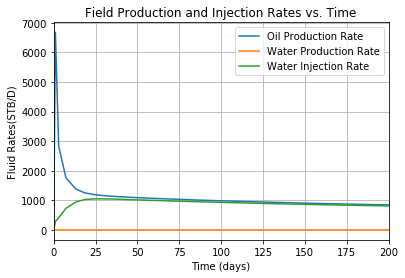

In [60]:
# Synchronous HTTP request (no intermidate updates are return from remote server)
job_id = run_remote_job(data_no_updates, SIM_URL, token)            

### 6.2 Perform multiple runs with different simulation durations
In the section, we illustrate how to perform multiple simulations with varying total simulation days (durations). In the example below we use the same data as the previous examples but vary the total simulation period from 100 to 500 days at intervals of 100 days. This is reflected in the results. The user is welcome to try different intervals.

Performing remote simulations 1 of 2
Step 1 - Submitting job to remote server: simulation duration 100 days ...
Step 2 - Constructing production (time-series) plots ...
Step 3 - Completed job. Job ID = b18a566e-01c4-4335-a9a1-075c762db2e4

Performing remote simulations 2 of 2
Step 1 - Submitting job to remote server: simulation duration 200 days ...
Step 2 - Constructing production (time-series) plots ...
Step 3 - Completed job. Job ID = 33c172a8-17c2-4e9d-a383-9d8ebf67b332



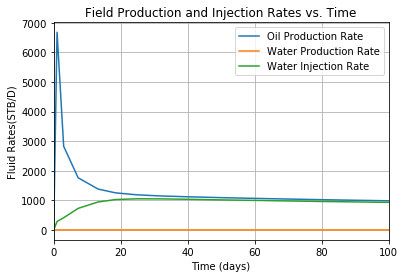

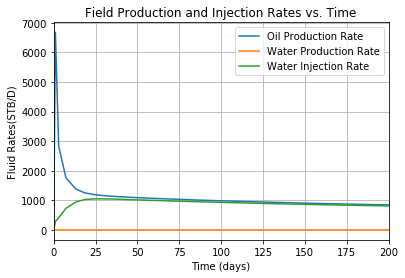

In [61]:
durations = [100, 200]
num_cases = len(durations)
for i, duration in enumerate(durations):
    print(f'Performing remote simulations {i+1} of {num_cases}')
    data_no_updates['simulation-duration'] = duration
    run_remote_job(data_no_updates, SIM_URL, token)
    print('')
    

### 6.3 Retrieve Job Results

After a job is completed, it can be retrieved again (via a GET request) if we know it's job id. Use the job id from the previous run in Section 6.1 or 6.2. After the first GET request, the results are cached, so subsequent requests to retrieve the same job is faster.

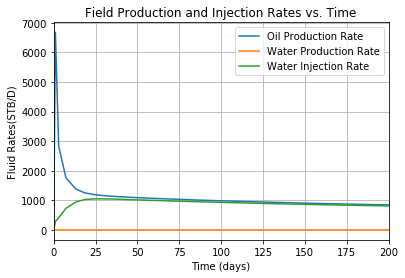

In [62]:
auth_headers = {"Authorization" : f"Token {token}"}
hello_data   = None
url          = f'https://simapi.thedibia.com/api/simulations/{job_id}'
results      = get_request_auth(hello_data, url, auth_headers)
if results:
    #print_json(results)
    make_plot(results)

## 7. Conclusion

This notebook shows a simple demonstration of performing physics simulation on a remote server. Please send an email to jerome.onwunalu@thedibia.com if you encounter problems while trying to run the notebook.